## 一 项目简介
- 1 该项目使用Labelimg进行数据标注，自定义数据集；
- 2 使用Paddlex将数据集划分为训练集、测试集；
- 3 使用PaddleDetection目标检测套件训练模型；
- 4 最后导出模型，通过PaddleLite生成.nb文件，部署到手机上；
- 5 安卓部署详细操作；
- （1）配置系统环境
- （2）下载PaddleLite-dome
- （3）下载Android Studio开发环境并配置软件环境
- （4）dome调试
- （5）根据dome，加入自己的模型，修改配置，实现自己的dome，并调试
- （6）将APP打包成可安装程序.apk文件
- 实现飞桨框架深度学习模型从0到1的全流程。

## 二 数据标注
- 个人建议安装Anaconda便于对包环境的管理，在Anaconda环境中安装Labelimg（b站有这类教学视频，若还有不明白的地方可评论区解答）
- 下面讲解安装成功后操作流程
- 1 新建数据集文件夹：JPEGImages文件存放事先准备好的图片，Annotations文件存放xml标注文件（未标注时此文件为空）

![](https://ai-studio-static-online.cdn.bcebos.com/2a4d694177f34f9db0803fc20b1706f68936d2f4282a43fa84e60f9f3e5baef3)

- 2 打开Labelimg：点击Change Save Dir找到刚刚创建的Annotations文件；点击Open Dir找到JPEGImages文件；快捷键按D，拖拽选中区域，并在弹框内打标签；点击Next Image对下一张图片进行标注（此时会弹出是否保存的提示框，可勾选View->Auto Save mode，默认将每张图片标注完后自动保存）

![](https://ai-studio-static-online.cdn.bcebos.com/4df4a9df88e1461b8a7310cdd9fc457174ed4e96c0f84108babe41c89a34cb31)

- 3 上述步骤完成后，Annotations文件中会产生一堆xml文件，格式如下，

![](https://ai-studio-static-online.cdn.bcebos.com/b5a62383c4c84248ad7b541afd8fb7fd1294ca7ca46b4691bce937476a31110b)

- 4 最后将文件压缩上传到aistudio

## 三 paddlex划分数据集

In [ ]:
#将数据集进行解压（此处可换成你自己标注的数据集）
!unzip data/data88819/VOC_MASK.zip -d masks

In [ ]:
# 准备一些可能用到的工具库
import xml.etree.cElementTree as ET
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import paddle.fluid as fluid
import time
import random

In [ ]:
# 导入paddlex
!pip install paddlex

In [ ]:
# 使用paddlex进行数据集的划分训练集、验证集、测试集
!paddlex --split_dataset --format VOC --dataset_dir masks/VOC_MASK --val_value 0.2 --test_value 0.1

Dataset Split Done.
Train samples: 5567
Eval samples: 1590
Test samples: 795
Split files saved in masks/VOC_MASK


执行完上述代码可以看到，masks/VOC_MASK目录下会自动生成以下文件：

- val_list.txt 验证集列表
- test_list.txt 测试集列表
- labels.txt 标签列表
- train_list.txt 训练集列表

## 四 PaddleDetection目标检测套件使用，进行模型的创建、训练、导出

### 1 PaddleDetection下载、配置、数据集文件的处理

In [ ]:
# 下载PaddleDetection到本地
# 为避免因PaddleDetection更新导致代码报错，我将我的PaddleDetection版本挂载到数据集里了data/data88824/model_PaddleDetection.zip，可解压使用
!git clone https://gitee.com/paddlepaddle/PaddleDetection.git

In [ ]:
# 把PaddleDetection转移到work目录下，可以持久保存
!mv PaddleDetection work/

In [ ]:
#配置PaddleDetection环境
!pip install -r work/PaddleDetection/requirements.txt

In [ ]:
#将数据集转到PaddleDetection/dataset，专门存放和处理数据集的文件
!cp -r masks/VOC_MASK work/PaddleDetection/dataset/

In [ ]:
%cd work/PaddleDetection

/home/aistudio/work/PaddleDetection


In [ ]:
# 调整下标注文件命名，与PaddleDetection默认的一致（处理成相同文件名）
!mv dataset/VOC_MASK/labels.txt dataset/VOC_MASK/label_list.txt

### 2 修改模型文件

#### 修改模型主文件ssd_mobilenet_v1_300_120e_voc.yml
此处用的SSD模型，主干网络是Mobilnet（比VGG更轻量级的网络，适合于移动端部署），图片输入尺寸300x300，数据集格式voc

- ssd_mobilenet_v1_300_120e_voc.yml 文件入口

文件地址：work/PaddleDetection/configs/ssd/ssd_mobilenet_v1_300_120e_voc.yml
```
_BASE_: [
  '../datasets/voc.yml',
  '../runtime.yml',
  '_base_/optimizer_120e.yml',
  '_base_/ssd_mobilenet_v1_300.yml',
  '_base_/ssd_mobilenet_reader.yml',
]
weights: output/ssd_mobilenet_v1_300_120e_voc/model_final # 模型权重文件保存路径
```

- voc.yml 主要说明了训练数据和验证数据的路径
文件地址：work/PaddleDetection/configs/datasets/voc.yml
```
metric: VOC
map_type: 11point
num_classes: 3  # 类别数+1（背景类）

TrainDataset:
  !VOCDataSet
    dataset_dir: dataset/VOC_MASK  # 数据集存放位置
    anno_path: train_list.txt    # 训练集
    label_list: label_list.txt   # 标签
    data_fields: ['image', 'gt_bbox', 'gt_class', 'difficult']

EvalDataset:
  !VOCDataSet
    dataset_dir: dataset/VOC_MASK   # 数据集存放位置
    anno_path: val_list.txt    # 验证集
    label_list: label_list.txt  # 标签
    data_fields: ['image', 'gt_bbox', 'gt_class', 'difficult']

TestDataset:
  !ImageFolder
    anno_path: dataset/VOC_MASK/label_list.txt  # 标签文件所在地址
```

- runtime.yml 主要说明了公共的运行参数，比如说是否使用GPU、每多少个epoch存储checkpoint等。
文件地址：work/PaddleDetection/configs/runtime.yml
```
use_gpu: true  # 使用gpu
log_iter: 20  
save_dir: output
snapshot_epoch: 1  # 1个epoch输出验证
```

- optimizer_120e.yml 主要说明了学习率和优化器的配置。
文件地址：work/PaddleDetection/configs/ssd/_base_/optimizer_120e.yml
```
epoch: 20  # 训练轮次

LearningRate:
  base_lr: 0.001  # 学习率
  schedulers:
  - !PiecewiseDecay
    milestones: [40, 60, 80, 100]
    values: [0.001, 0.0005, 0.00025, 0.0001, 0.00001]
    use_warmup: false

OptimizerBuilder:  # 优化器
  optimizer:
    momentum: 0.0
    type: RMSProp
  regularizer:
    factor: 0.00005
    type: L2
```

- ssd_mobilenet_v1_300.yml 主要说明模型、和主干网络的情况。
文件地址：work/PaddleDetection/configs/ssd/_base_/ssd_mobilenet_v1_300.yml

- ssd_mobilenet_reader.yml 主要说明数据读取器配置，如batch size，并发加载子进程数等，同时包含读取后预处理操作，如resize、数据增强等等-。
文件地址：work/PaddleDetection/configs/ssd/_base_/ssd_mobilenet_reader.yml

> - 更多详细操作参考[PaddleDetection的github链接](https://github.com/PaddlePaddle/PaddleDetection)

### 3 模型训练

In [4]:
# 配置文件在work/PaddleDetection/configs/ssd/ssd_mobilenet_v1_voc.yml，模型保存在work/PaddleDetection/output
# 可使用可视化工具VisualDL,文件在work/PaddleDetection/vdl_log_dir（需要模型运行时才能产出）
!python -u tools/train.py -c configs/ssd/ssd_mobilenet_v1_300_120e_voc.yml --use_vdl True --eval

> - 由于时间原因，没训练多少次

![](https://ai-studio-static-online.cdn.bcebos.com/d202c5e9d71c4a669af3286802a50d91dd154b7db84241e584cf2285b8b78e2d)

![](https://ai-studio-static-online.cdn.bcebos.com/2a58fb65d2e24427b768f3b84a5305447bbf14f05ce54ad8a4448b27ea89e47e)


### 4 模型预测效果展示

In [5]:
#测试，查看模型效果，结果存放在work/PaddleDetection/output
%cd /home/aistudio/work/PaddleDetection/
!python tools/infer.py -c configs/ssd/ssd_mobilenet_v1_300_120e_voc.yml --infer_img=/home/aistudio/001.jpg -o weights=output/ssd_mobilenet_v1_300_120e_voc/best_model.pdparams

In [6]:
%cd /home/aistudio/

/home/aistudio


In [7]:
import matplotlib.pyplot as plt
import PIL.Image as Image

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


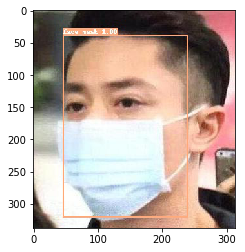

In [8]:
path='work/PaddleDetection/output/001.jpg'
img = Image.open(path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像

### 5 模型导出

In [9]:
%cd /home/aistudio/work/PaddleDetection/

In [10]:
# 导出模型
!python tools/export_model.py -c configs/ssd/ssd_mobilenet_v1_300_120e_voc.yml -o weights=output/ssd_mobilenet_v1_300_120e_voc/best_model.pdparams --output_dir ./inference

## 五 PaddleLite生成.nb模型文件
[PaddleLite文档](https://paddle-lite.readthedocs.io/zh/latest/demo_guides/android_app_demo.html)

In [1]:
# 准备PaddleLite依赖
!pip install paddlelite

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 45.8MB 6.1MB/s eta 0:00:011


In [2]:
%cd /home/aistudio/work/PaddleDetection/

/home/aistudio/work/PaddleDetection


In [3]:
# 准备PaddleLite部署模型
#--valid_targets中参数（arm）用于传统手机，（npu,arm ）用于华为带有npu处理器的手机
!paddle_lite_opt \
    --model_file=inference/ssd_mobilenet_v1_300_120e_voc/model.pdmodel \
    --param_file=inference/ssd_mobilenet_v1_300_120e_voc/model.pdiparams \
    --optimize_out=./inference/ssd_mobilenet_v1_300_120e_voc \
    --optimize_out_type=naive_buffer \
    --valid_targets=arm 
    #--valid_targets=npu,arm 

Loading topology data from inference/ssd_mobilenet_v1_300_120e_voc/model.pdmodel
Loading params data from inference/ssd_mobilenet_v1_300_120e_voc/model.pdiparams
1. Model is successfully loaded!
[W  7/20 19: 8: 3.101 /island/Paddle-Lite/lite/core/program.cc SaveToProgram:135] Unsupported decl type Tensor<host,any,any,0> for var _generated_var_5 in op conditional_block
[W  7/20 19: 8: 3.101 /island/Paddle-Lite/lite/core/program.cc SaveToProgram:135] Unsupported decl type Tensor<host,any,any,0> for var _generated_var_2 in op conditional_block
2. Model is optimized and saved into ./inference/ssd_mobilenet_v1_300_120e_voc.nb successfully


## 六 安卓端部署

### 1 准备Android Studio开发环境（安装系统为Ubuntu 64-bit，Win用户可以安装虚拟机进行操作）
- 快捷键Ctrl+Alt+t打开终端，安装64位所需库
```
sudo apt-get install libc6:i386 libncurses5:i386 libstdc++6:i386 lib32z1 libbz2-1.0:i386
```
- 安装java环境（作者使用的是OpenJDK 8 ）

查看java版本
```
java --version  
```
下载OpenJDK 8
```
sudo apt-get install openjdk-8-jdk
```
若系统存在多个版本的java，输入对应选项的数字切换Java版本（初次安装则不需要执行下面）
```
update-alternatives --config java
```
- 安装cmake和ninja环境
```
# root用户进入命令
sudo su
# root用户退出命令
exit
```
```
# 1. Install basic software 参考官方文档，注意权限，应该是root用户
apt update
apt-get install -y --no-install-recommends \
  gcc g++ git make wget python unzip adb curl

# 2. Install cmake 3.10 or above 参考官方文档，注意权限，应该是root用户
wget -c https://mms-res.cdn.bcebos.com/cmake-3.10.3-Linux-x86_64.tar.gz && \
    tar xzf cmake-3.10.3-Linux-x86_64.tar.gz && \
    mv cmake-3.10.3-Linux-x86_64 /opt/cmake-3.10 && \  
    ln -s /opt/cmake-3.10/bin/cmake /usr/bin/cmake && \
    ln -s /opt/cmake-3.10/bin/ccmake /usr/bin/ccmake
    
# 3. Install ninja-build 此处需退出root用户
sudo apt-get install ninja-build
```
- Android Studio软件安装流程参考官方视频：
[Ubuntu上推荐的设置流程](https://developer.android.google.cn/studio/videos/studio-install-linux.mp4?hl=zh-cn)

> 注意：安装过程中会如果出现下面的报错`unable to access android sdk add-on lis`，点击`cancel`跳过，这是因为没有事先安装SDK的原因，我们稍后在Android Studio中进行安装。


### 2 导入Paddle-Lite-Demo
- 在自己的PC上下载好Paddle-Lite-Demo项目（下面的代码新开一个终端执行，不要在运行Android Studio的终端上操作）
```
git clone https://gitee.com/paddlepaddle/Paddle-Lite-Demo.git
```
- 在Android Studio中导入PaddleLite-android-demo目录下object_detection_demo项目，如下图所示
![](https://ai-studio-static-online.cdn.bcebos.com/5a3e9a690cc241a7a31726999041487d9d6126ca586e43eeb3288d4bdb88143d)


### 3 配置SDK和NDK
- 在开发界面点击File->Settings... 在搜索框中输入sdk
![](https://ai-studio-static-online.cdn.bcebos.com/cc469b4918f941898293159bfd895227823d7dede0fd44b8a605cc077178974f)


![](https://ai-studio-static-online.cdn.bcebos.com/6212319e0c2b427692963692167878e780bc0f2c2b514cb4b397dda10d93a2ce)

- 在开发界面点击File->Project Structure,选取刚刚下载的NDK路径
![](https://ai-studio-static-online.cdn.bcebos.com/9e2529ce745b41eba29ece05a8e1b563f8db5f0621f04c7a81365f8fa7ffcb49)


### 4 模型和标签的拷贝
- 模型拷贝
到PaddleLite-android-demo/object_detection_demo/app/src/main/assets/models目录下，新建ssd_mobv1_mask文件夹，将刚刚生成的.nb文件拷贝到该文佳夹下，并重命名为model.nb,如下图所示。（模型文件我挂载项目的data数据集里了，可先尝试一下）

![](https://ai-studio-static-online.cdn.bcebos.com/c9c227435c7840339c25e1b4a39bc3613c805dd5b1f54347a90fdb93d6bbfcdd)
- 标签拷贝
到PaddleLite-android-demo/object_detection_demo/app/src/main/assets/labels目录下，仿照已有.txt文件新建一个face.txt文件（注意label文件中是background+你数据集的label）,内容如下
```
background
face
face_mask
```
- 拷贝一张测试图片
到PaddleLite-android-demo/object_detection_demo/app/src/main/assets/images目录下，拷贝一张项目初始化测试的图片

### 5 修改项目文件
- 修改PaddleLite-android-demo/object_detection_demo/app/src/main/res/values/strings.xml中对应的参数
- MODEL_DIR_DEFAULT  模型路径
- LABEL_PATH_DEFAULT  标签路径
- IMAGE_PATH_DEFAULT  项目初始化测试图片路径
![](https://ai-studio-static-online.cdn.bcebos.com/87d9f0665b3948ff861d5b7b7ff317d49eb76a98060446c2b6b12792d5c836df)



### 6 准备手机
- 将手机调为开发者模式，将手机通过USB数据线连接到PC上，点击运行，等待一会就好了

![](https://ai-studio-static-online.cdn.bcebos.com/5313783414c44aa9a4b42d4e9f0eb89b1f13e037964943c3a3e5fcd63169ce18)


### 7 效果展示
- 项目初始界面

![](https://ai-studio-static-online.cdn.bcebos.com/5f0d0f51405140f5851ea64df667550a55b7c04e2cda428e9072ef3a5d1ee01c)

- 项目通过相机拍取画面（因为拍的是电脑屏幕，看起来有点花）

![](https://ai-studio-static-online.cdn.bcebos.com/0393f99bd4c8424792a7b364591674d0d735a2b92f104a7794299c95fa432ff7)

- 项目通过调取手机相册的图片

![](https://ai-studio-static-online.cdn.bcebos.com/0ef09fa72c154de38011768e929da42c30100be8f1b84298adbd1cf12d44aaa1)


### 8 apk打包
- 在工具栏中点击如下

![](https://ai-studio-static-online.cdn.bcebos.com/95f2e78c14884f848f9fe74876cc35a76a7c8db4c8e344f391254c5799d7b098)

- 选择打包成apk

![](https://ai-studio-static-online.cdn.bcebos.com/3402e2b846eb40e3af641310570336f0beba431d9b6e45acbf1acca25d3bf214)

- 若第一次打包，需创建新的秘钥文件

![](https://ai-studio-static-online.cdn.bcebos.com/f3815daadd0745fe8c205941b53f53d13c59892007704279bba41af6e4a55233)

- 创建成功后

![](https://ai-studio-static-online.cdn.bcebos.com/06d714fce76946e4b0ccb046ccfe1aacd459e5d0d28c4f058a04030304ab2671)

- next，v1、v2都勾选上

![](https://ai-studio-static-online.cdn.bcebos.com/c2c9e656978841dd9f27a95364a7e433f647d8076beb47be8200976527425ef0)

- 打包成功

![](https://ai-studio-static-online.cdn.bcebos.com/164757219405423ca713a81271451b3b0c8bbe2c6ed8458abc6662348e01ae63)


## 小结
> - 本次部署选择object_detection_demo是考虑到有的小伙伴想做其它方面的检测，给大家介绍一个通用的检测demo，若专门做口罩检测可选择mask_detection_demo
> - 如若存在问题，可在评论区留言，作者会不时为大家讲解
> - 作者aistudio主页链接，欢迎各位互粉、提问：[aistudio](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/539945)
> - 完结（#￣▽￣#）撒花

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 